# Sentiment Analysis for FIFA 2022 World Cup Matches using Twitter

Project Owner: Susovan Samanta

In this project we will be working on sentiment analysis of soccer matches as part of FIFA 2022 World Cup. We will use Python, Beatifulsoap, Tweepy, TextBlob, and BM25Okapi. 

This project is divided into mainly 6 segments.

1. Get the initial details for mentioned FIFA 2022 World cup match from a webpage. 
2. Do Twitter API authentication to search required tweets.
3. Using Textblob perform sentiment analysis for each team members.
4. Plotting the sentiment result into a bar chart for visual representation
5. Using BM25Okapi perform a positive sentiment Analysis for each players.
6. Plotting the sentiment result into a bar chart for visual representation

This notebook will work as a runbook to display of how the code works with the main code in my GitHub. For demonstration purpose I'm analyzing a match between United States and Netherlands occurred on December 3rd 2022

In [1]:
# import required libraries 
# pip install tweepy
# pip install BeautifulSoup4 

import datetime as datetime
import math
import numpy as np 
import pandas as pd 
from rank_bm25 import BM25Okapi 
import requests  # for HTTP request
import tweepy # api for twitter
from textblob import TextBlob  # library for processing textual data with NLTK (Natural Language Toolkit) 
import matplotlib.pyplot as plt  # data visualization library
from bs4 import BeautifulSoup  # HTML parser


# Setting Input Parameters

Setting input parameters for the match

In [2]:
# Input Parameters , We need to change these input paarmeters for every match 

#################################################

First_Team_name = 'United-States'
Second_Team_name = 'Netherlands'
Match_Date = 'December-3-2022'

##################################################
# Team name formatting

team1_name = First_Team_name.replace('-', ' ')
print(First_Team_name)

team2_name = Second_Team_name.replace('-', ' ')
print(Second_Team_name)


United-States
Netherlands


# Get the page data for FIFA World Cup 2022 matches

We will use beautiful soap to fetch and analyze webpage data

In [3]:
# Get the initial page data for FIFA World Cup 2022

fbref_url = "https://fbref.com/en/comps/1/World-Cup-Stats"
req = requests.get(fbref_url)

soup = BeautifulSoup(req.text, features="html.parser")
count = 0
while count <= 3:
    #print (count)
    # Read the main page table to collect team's hyperlink
    stat_table = soup.select('table.stats_table')[count]  
    # find all 'a' tags from the table
    a_tag = stat_table.find_all('a')
    
    # Get all the href link with 'Men-Stats' mentioned
    
    href_text = []

    for tag_text in a_tag:
        href_text.append(tag_text.get('href'))
    
    search_key = First_Team_name + '-Men-Stats'
   # print (search_key)
   # print(href_text)  
    
    url_text = []
    
    for text in href_text:
        #print(search_key)
        #print(text)
        if search_key in text:
            url_text.append(text)

            
    #print(url_text)        
    # Construct the url for first team
    first_team_url= []
    
    for text in url_text:
        if First_Team_name in text:
            first_team_url.append(f"https://fbref.com{text}")

    if not first_team_url:
        count = count +1
    else:
        req = requests.get(first_team_url[0])
        break;

################################################################################################################################

# Read Fixture table from the page
soup = BeautifulSoup(req.text, features="html.parser")
fixture_table = soup.select('table.stats_table')[2]  

# find all 'a' tags 
a_tag = fixture_table.find_all('a')

href_text = []

for tag_text in a_tag:
    href_text.append(tag_text.get('href'))

url_text = []

for text in href_text:
    if '/matches/' in text:
        if First_Team_name and Match_Date in text:
            url_text.append(text)


Match_url = []

for url in url_text:
    Match_url.append (f"https://fbref.com{url}" )

print(Match_url[0])

https://fbref.com/en/matches/249ccad4/Netherlands-United-States-December-3-2022-World-Cup


# Select Players

Select Players from both teams who played that match

In [4]:
####################################################
# Select Players
####################################################

req = requests.get(Match_url[0])
soup = BeautifulSoup(req.text, features="html.parser")

team1_stats_table = team1_name + ' ' + 'Player Stats'
team1_players = pd.read_html(req.text, match=team1_stats_table)[0]
team1_players.columns = team1_players.columns.droplevel()
team1_players.drop(team1_players.tail(1).index,inplace=True)

for total_players_team1,name in enumerate(team1_players["Player"]):
    print(name)
    
team2_stats_table = team2_name + ' ' + 'Player Stats'
team2_players = pd.read_html(req.text, match=team2_stats_table)[0]
team2_players.columns = team2_players.columns.droplevel()
team2_players.drop(team2_players.tail(1).index,inplace=True)


for total_players_team2,name in enumerate(team2_players["Player"]):
    print(name)

Jesús Ferreira
Gio Reyna
Christian Pulisic
Timothy Weah
Brenden Aaronson
Weston McKennie
Haji Wright
Tyler Adams
Yunus Musah
Antonee Robinson
Jordan Morris
Tim Ream
Walker Zimmerman
Sergiño Dest
DeAndre Yedlin
Matt Turner
Memphis
Xavi Simons
Cody Gakpo
Wout Weghorst
Davy Klaassen
Teun Koopmeiners
Frenkie de Jong
Marten de Roon
Steven Bergwijn
Daley Blind
Denzel Dumfries
Nathan Aké
Matthijs de Ligt
Virgil van Dijk
Jurriën Timber
Andries Noppert


# API Authentication

In [5]:
#####################################################################
# Import API Keys for Twitter
#####################################################################

consumer_key = ' '
consumer_secret = ' '
access_token = ' '
access_token_secret = ' '
bearer_token = ' '


# Authentication
auth = tweepy.OAuth1UserHandler(consumer_key, consumer_secret, access_token, access_token_secret)
client = tweepy.Client(bearer_token=bearer_token, wait_on_rate_limit=True)

###



# Sentiment Analysis for each players from both teams


In [6]:
team1_all_sentiment = []  # team's senitment
team1_all_tweets = []  # Store all the tweets
team1_all_tweets_sentiments = []  # combined above two

team2_all_sentiment = []  
team2_all_tweets = []  
team2_all_tweets_sentiments = []  


threshold = 0.12  # threshold for subjectivity

### setting date range

new_date = datetime.datetime.strptime(Match_Date,'%B-%d-%Y').strftime('%Y-%m-%d')
date_until = datetime.datetime.strptime(new_date,'%Y-%m-%d') + datetime.timedelta(days=5)

print(date_until)


#Sort Function
def sort_key(elem):  
    return elem[1]


# Sentiment Analysis

team_count = 1
while team_count <= 2:
    

    if team_count == 1:
        players = team1_players["Player"]
        team_all_tweets = team1_all_tweets
        team_all_tweets_sentiments = team1_all_tweets_sentiments
        team_all_sentiment = team1_all_sentiment
        #print("team1")
    else:
        players = team2_players["Player"]
        team_all_tweets = team2_all_tweets
        team_all_tweets_sentiments = team2_all_tweets_sentiments
        team_all_sentiment = team2_all_sentiment
        #print("team2")

    for player in players:  
        joint = player
        joint = joint.replace(" ","")
        #print(player)
        

        api = tweepy.API(auth, wait_on_rate_limit=True)
        tweets = tweepy.Cursor(api.search_tweets,q= player or joint,until=date_until, result_type = "recent" ).items() # find tweets for each player

        players_tweets = []
        players_sentiments = []
        players_tweets_sentiments = []
        
        #print("got tweets")

        # Store tweets and sentimemnt in different placeholders
        for tweet in tweets: 
            players_tweets.append(tweet.text)
            players_sentiments.append(TextBlob(tweet.text).sentiment)  
            
            #print("1")

        for l in range(0, len(players_tweets)):  # Store tweets and sentiment together
            players_tweets_sentiments.append([players_tweets[l], players_sentiments[l]])
            players_tweets_sentiments.sort( key=sort_key)  # Sort it in ascending order of sentiment

            team_all_tweets.append(players_tweets)  # create array of just the tweets
            team_all_tweets_sentiments.append( players_tweets_sentiments)  # create array of all of the player tweets, which are now sorted by sentiment
                
            #print("2")

        sub_sentiment = 0  
        pl_sentiment = 0 
        
        for sentiment in players_sentiments:
            if sentiment[1] >= threshold: 
                sub_sentiment = sub_sentiment + 1
                pl_sentiment = pl_sentiment + sentiment[0]
                
    
        if pl_sentiment == 0:
            team_all_sentiment.append([player, 0, sub_sentiment])  
        else:
            team_all_sentiment.append([player, pl_sentiment / sub_sentiment, sub_sentiment])
                
    team_count = team_count + 1

2022-12-08 00:00:00


# Visual Represenation of Sentiment

In [7]:
team1_all_sentiment.sort(key=sort_key)
team2_all_sentiment.sort(key=sort_key)


# create index for team 1
team1_Index = []
team1_Sentiment = []
for i in team1_all_sentiment:
    team1_Index.append(i[0])
    team1_Sentiment.append(round(i[1],3))

# create index for team 2
team2_Index = []
team2_Sentiment = []
for i in team2_all_sentiment:
    team2_Index.append(i[0])
    team2_Sentiment.append(round(i[1],3))

# Team1 horizontal bar chart

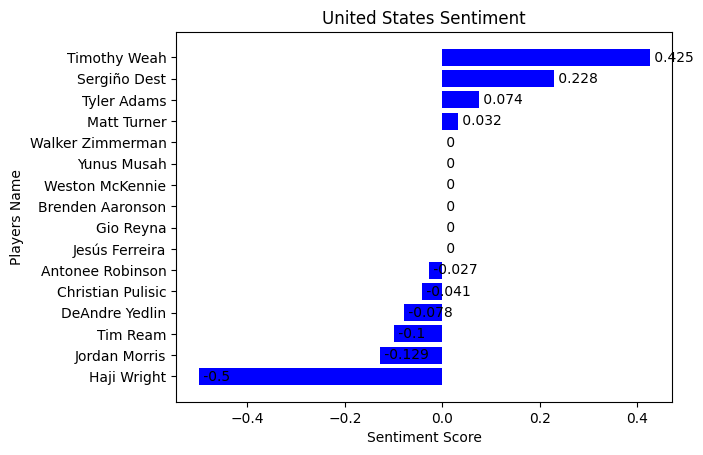

In [8]:
fig, ax = plt.subplots()
ax.barh(team1_Index, team1_Sentiment, color = "blue")
plt.title(team1_name + ' Sentiment')
plt.xlabel('Sentiment Score')
plt.ylabel('Player''s Name')

for i, v in enumerate(team1_Sentiment):
    ax.text(v, i, " " + str(v), color='black', va = 'center')
    
object_name = team1_name + '_senteminet.png'
plt.savefig(object_name)

# Team2 horizontal bar chart

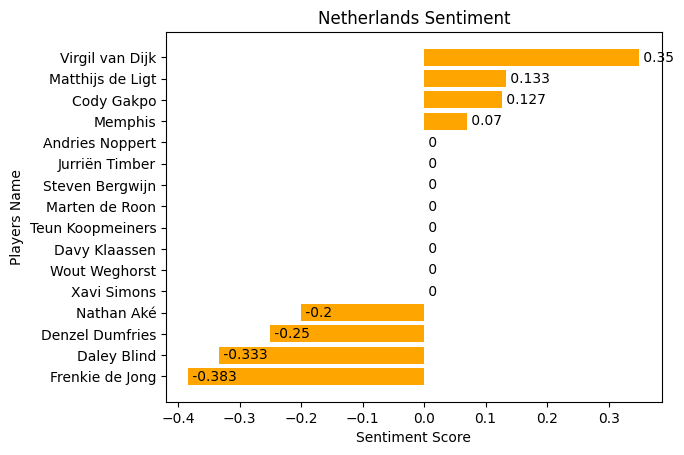

In [9]:
fig, ax = plt.subplots()
ax.barh(team2_Index, team2_Sentiment, color = "orange")
plt.title(team2_name + ' Sentiment')
plt.xlabel('Sentiment Score')
plt.ylabel('Player''s Name')
    
for i, v in enumerate(team2_Sentiment):
    ax.text(v, i, " " + str(v), color='black', va = 'center')
    
object_name = team2_name + '_senteminet.png'
plt.savefig(object_name)

# Implementing BM25Okapi with terms

In [10]:
team1_tweets = [] 
team2_tweets = []
team1_positive = []
team2_positive = []

sample_size = 50

positive_terms = "gols gol good score goal pass Assist assistência strike lead win bueno" 
tokenized_positive_term = positive_terms.split(" ")

#Collect all the tweets
for l in range(0,len(team1_all_tweets)):
    team1_tweets = team1_tweets + team1_all_tweets[l] 

team1_tokenized_tweets = [doc.split(" ") for doc in team1_tweets] 

for l in range(0, len(team2_all_tweets)):
    team2_tweets = team2_tweets + team2_all_tweets[l]

team2_tokenized_tweets = [doc.split(" ") for doc in team2_tweets] 

all_tweets = team1_tweets + team2_tweets # combine both player tweets into one corpus



# implementation of BM25Okapi to rank tweets

def BM25_score(tokenized_corpus, terms): # BM25 Ranking
    bm25 = BM25Okapi(tokenized_corpus)
    score = bm25.get_scores(terms)
    return score


positive_array = BM25_score(team1_tokenized_tweets,tokenized_positive_term)
team1_positive_array = positive_array[0:sample_size*(total_players_team1+1)] 

#print(team1_positive_array)

positive_array = BM25_score(team2_tokenized_tweets,tokenized_positive_term)
team2_positive_array = positive_array[0:sample_size*(total_players_team2+1)] 

#print(team2_tokenized_tweets)

mod_number = math.trunc(len(team1_positive_array) / (total_players_team1+1))
max_array_size = (total_players_team1+1) * mod_number

#print(len(team1_positive_array) ) 
#print(total_players_team1)

#print((mod_number) ) 
#print((max_array_size) )
#print (total_players_team1+1)

# postive tweets
team1_positive_results = np.sum(np.reshape(team1_positive_array[0:max_array_size],(total_players_team1+1,mod_number)),axis=1)/50

mod_number = math.trunc(len(team2_positive_array) / (total_players_team2+1))
max_array_size = (total_players_team2+1) * mod_number

#print(len(team2_positive_array) ) 
#print((mod_number) ) 
#print((max_array_size) )
#print (total_players_team2+1)


team2_positive_results = np.sum(np.reshape(team2_positive_array[0:max_array_size],(total_players_team2+1,mod_number)),axis=1)/50


# reshape sum arrays for graphing

team1_positive_results = np.round(np.reshape(team1_positive_results,(1,(total_players_team1+1))).tolist(),5)
team2_positive_results = np.round(np.reshape(team2_positive_results,(1,(total_players_team2+1))).tolist(),5)

#print (team1_positive_results)

# Team1 BM25 Ranking horizontal bar chart

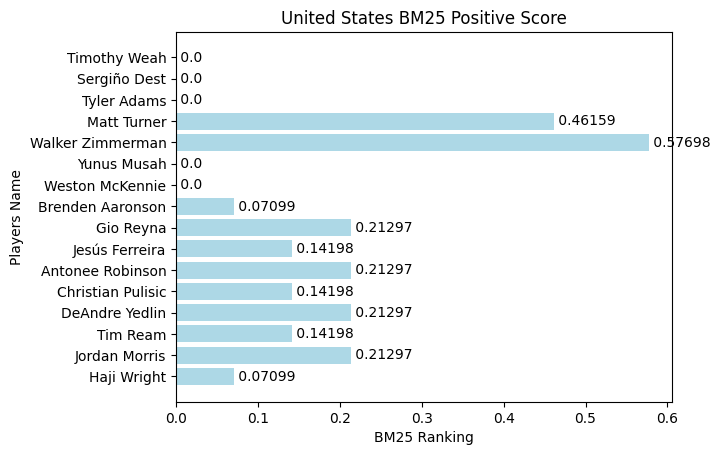

In [11]:
fig, ax = plt.subplots()
ax.barh(team1_Index, team1_positive_results[0], color = "lightblue")
plt.title(team1_name + ' BM25 Positive Score' )
plt.xlabel('BM25 Ranking')
plt.ylabel('Players Name')
for i, v in enumerate(team1_positive_results[0]):
    ax.text(v, i, " " + str(v), color='black', va = 'center')

object_name = team1_name + '_BM25_Sentiment.png'
plt.savefig(object_name)


# Team2 BM25 Ranking horizontal bar chart

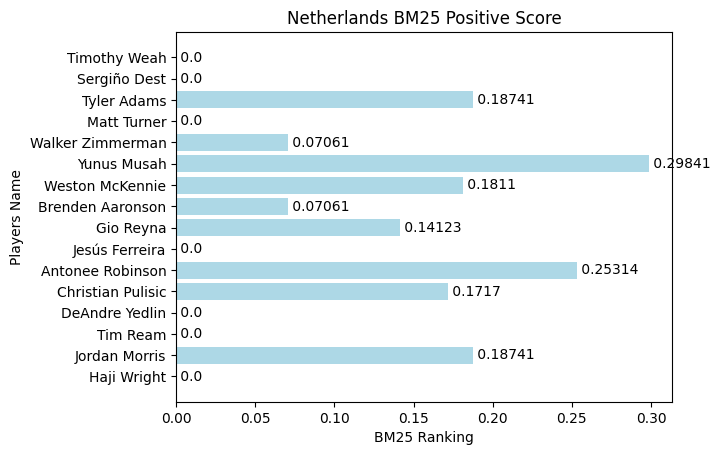

In [12]:
fig, ax = plt.subplots()
ax.barh(team1_Index, team2_positive_results[0], color = "lightblue")
plt.title(team2_name + ' BM25 Positive Score' )
plt.xlabel('BM25 Ranking')
plt.ylabel('Players Name')
for i, v in enumerate(team2_positive_results[0]):
    ax.text(v, i, " " + str(v), color='black', va = 'center')

object_name = team2_name + '_BM25_Sentiment.png'
plt.savefig(object_name)


# Conclusion

This code gives a basic structure of sentiment analysis using Textblob and also use OkapiBM25 for positive sentiment analysis based on positive terms.

# Potential Improvements

The code can be more effecient in general. And potential imporvements are below.
1. We can implement negative sentiment also with given positive sentiment.
2. Language restriction was a challenge while implementing the sentiment analysis. As it is a world cup game, people are tweeting from across the globe and most of them in Spanish, Portuguese which should be implemented properly in the algorithm.
